<div style="text-align: center;">
    <img src="https://gershenson.mx/wp-content/uploads/2020/08/logo-tec-de-monterrey-e1484853084274.png" alt="Tecnológico de Monterrey" width="300"/>
</div>

---

<div style="text-align: center;">

# **Procesamiento del PDF SAE J1939-71 y construcción del JSON de referencia para RAG**

## **Proyecto Integrador**

### **Tecnológico de Monterrey**
### **Escuela de Ingeniería y Ciencias**

---

### **Equipo 7**

| **Nombre del Autor** | **Código** |
|:---------------------|:-----------|
| Henry Junior Aranzales López | A01794020 |
| Jorge Arturo Hernández Morales | A01794908 |
| Luis Alejandro González Castellanos | A01795481 |

---

### **Fecha:** Octubre 26 de 2025

### **Resumen Ejecutivo**

Se diseñó e implementó un pipeline de extracción que obtiene el texto del PDF página a página, identifica y parsea bloques de definiciones de SPN mediante expresiones regulares tolerantes a variaciones de formato, normaliza atributos clave (longitud, resolución, offset, rango, tipo) y ensambla un JSON estructurado con secciones de metadata, guidelines, dbc_linkage, spns, pgns y traceability. Este JSON sirve como base para indexación semántica en un sistema RAG y facilita la posterior conciliación con archivos DBC para derivar posiciones de bits y nombres de señales definitivos.

---

</div>

## Índice

1. Introducción y objetivos
2. Fundamento teórico: SAE J1939-71
3. Arquitectura del pipeline
4. Diseño del algoritmo y especificación del parser
5. Estructura del JSON de referencia
6. Validación y resultados
7. Rendimiento y contratiempos
8. Conclusiones
9. Próximos pasos


## 1. Introducción y objetivos

Este trabajo presenta el proceso seguido para transformar la información del PDF SAE J1939-71 en un artefacto estructurado (JSON) útil para un sistema RAG. Se priorizó la trazabilidad, la claridad de los campos y la compatibilidad futura con archivos DBC.

Objetivos específicos:
- Extraer programáticamente las definiciones de SPN con sus atributos principales.
- Ensamblar un JSON autodescriptivo y estable para indexación semántica.
- Definir lineamientos de vinculación con DBC sin duplicar responsabilidades.
- Documentar supuestos, decisiones y limitaciones.

## 2. Fundamento teórico: SAE J1939-71

SAE J1939-71 define la Capa de Aplicación del estándar J1939, especificando Parámetros Sospechosos (SPN) y Números de Grupo de Parámetros (PGN). Cada SPN representa una magnitud medida o un estado de sistema, y puede pertenecer a uno o más PGN. Los mensajes se transmiten sobre CAN de 29 bits, descomponiendo el identificador en prioridad, página de datos, formato PDU (PF), específico PDU (PS) y dirección de origen (SA).

Terminología esencial:
- SPN: identificador único del parámetro con semántica definida por J1939-71.
- PGN: agrupación lógica que determina el contenido del mensaje.
- DBC: especificación de mensajes y señales a nivel de bits para buses CAN.


## 3. Arquitectura del pipeline

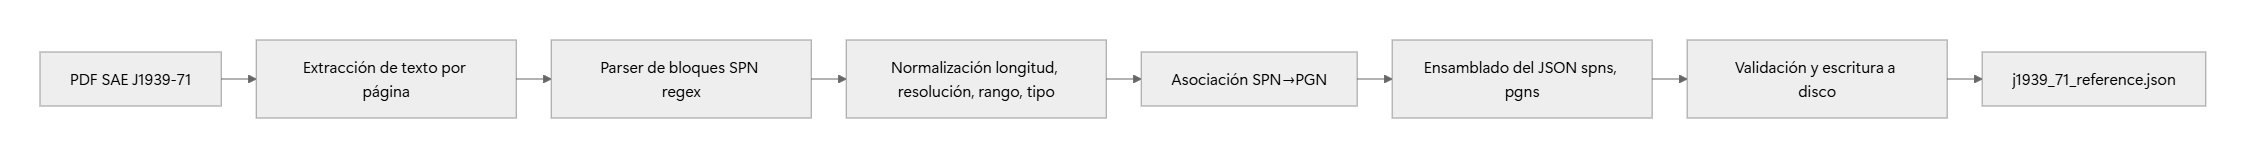

### Descripción detallada de la arquitectura del pipeline

El pipeline está organizado en etapas claramente separadas que siguen el diagrama de flujo. Cada etapa es una unidad con responsabilidades bien definidas, interfaces de entrada/salida y puntos de observabilidad para facilitar pruebas, depuración y escalado.

| # | Componente / Descripción |
|---:|---|
| 1 | Entrada y orquestación<br>- Entrada: archivo PDF (ruta local o URI).<br>- Orquestador: controlador principal (MAX_PAGES, buffer, concurrencia).<br>- Contratos: estructuras JSON/parciales entre etapas. |
| 2 | Extracción de texto por página<br>- Motor: PyMuPDF (fitz).<br>- Lectura página-a-página con ventanas de N páginas.<br>- Salida: lista de bloques {page_start, page_end, raw_text, block_id}. |
| 3 | Buffer de cola y agrupamiento<br>- Buffer circular que acumula texto hasta heurística (n caracteres/patrón).<br>- Flush por separación fuerte o tamaño máximo. |
| 4 | Parser de bloques SPN (regex tolerante)<br>- Regex robustas (case-insensitive, espacios, saltos inesperados).<br>- Salida: objetos intermedios {spn_id, name_raw, …, source_block, loc}.<br>- Heurísticas de fallback y confidence_score. |
| 5 | Normalización de atributos<br>- Longitud → bits; resolución/offset → scale+offset numéricos.<br>- Rango → min/max y unidad; tipo semántico (Measured/State/Flag/Diagnostic).<br>- Salida: SPN canónico {spn, name, units, data_length_bits, scale, offset, min, max, type, pgns[]}. |
| 6 | Asociación SPN → PGN<br>- Normalización y extracción de PGNs (valores únicos, rangos).<br>- Una SPN puede mapear a múltiples PGNs.<br>- Posiciones de bits quedan "to-confirm" mediante DBC/cantools. |
| 7 | Ensamblado del JSON de referencia<br>- Estructura top-level: {metadata, guidelines, dbc_linkage, spns[], pgns[], traceability}.<br>- Campos de trazabilidad: source_block, page_range, raw_excerpt, confidence_score.<br>- Versionado: schema_version, created_at. |
| 8 | Validación y políticas de calidad<br>- Validaciones sintácticas y semánticas (units vs resolution, data_length).<br>- Reglas: SPNs duplicados, PGNs vacíos, SPNs sin PGN.<br>- Reporte de inconsistencias (warning/error) y métricas. |
| 9 | Persistencia y artefactos<br>- Escritura atómica de j1939_71_reference.json con backup y checksum.<br>- Artefactos: CSV/Parquet, logs de trazabilidad, reporte de validación. |
| 10 | Observabilidad y telemetría<br>- Logs estructurados (JSON) con niveles.<br>- Métricas: tiempo por etapa, SPNs por página, confidence promedio.<br>- Hooks para exportar a Prometheus o dashboard. |
| 11 | Resiliencia y rendimiento<br>- Procesamiento por ventanas y flush periódico (bajo consumo RAM).<br>- Paralelización por rango de páginas cuando convenga.<br>- Fallback OCR (tesseract) si extracción falla. |
| 12 | Trazabilidad y reproducibilidad<br>- Cada SPN referencia bloque original y texto crudo.<br>- Run_id para relacionar ejecuciones.<br>- Archivo de configuración (YAML/JSON) con parámetros de ejecución. |
| 13 | Integración con DBC y RAG<br>- DBC linkage: clave semántica = SPN; bit positions confirmadas con cantools.<br>- Preparación RAG: snippets/short_text para embeddings y metadatos para filtrado. |


Principios de diseño:
- Separación de responsabilidades: extracción, parsing, normalización y salida.
- Rendimiento: lectura por páginas con PyMuPDF y procesamiento por bloques con buffer de cola.
- Observabilidad: registro de progreso por páginas y conteos acumulados de SPNs.


## 4. Diseño del algoritmo y especificación del parser

Criterios de extracción:
- El encabezado del bloque inicia con la palabra clave "SPN" seguida de un identificador y el nombre del parámetro.
- Las líneas subsecuentes incluyen Data Length, Resolution, Data Range, Type, Suspect Parameter Number y Parameter Group Number.

Patrón regex de referencia (simplificado):

(?is)\bspn\s*([0-9]{3,6})\s*-\s*(.+?)\s*-\s*(.+?)\s*
Data\s+Length:\s*([^\n]+)\n
Resolution:\s*([^\n]+)\n
Data\s+Range:\s*([^\n]+)\n
Type:\s*([^\n]+)\n
Suspect\s+Parameter\s+Number:\s*([0-9]{3,6})\n
Parameter\s+Group\s+Number:\s*([^\n]+?)\s*(?=\n\s*spn\s*[0-9]{3,6}\s*-|\Z)

Normalización:
- Longitud: conversión a bits identificando "bytes" o "bits".
- Resolución y offset: extracción de escala por bit y offset cuando se declara.
- Rango: valores mínimos y máximos, con detección de unidades si no aparecen en Resolution.
- Tipo: clasificación en "Medido" o "Estado" cuando corresponde.
- PGNs: recopilación de identificadores citados en el bloque.


## 5. Estructura del JSON de referencia

El JSON final incluye las siguientes secciones de primer nivel: metadata, guidelines, dbc_linkage, spns, pgns y traceability. A continuación se presenta un diagrama conceptual de los componentes.

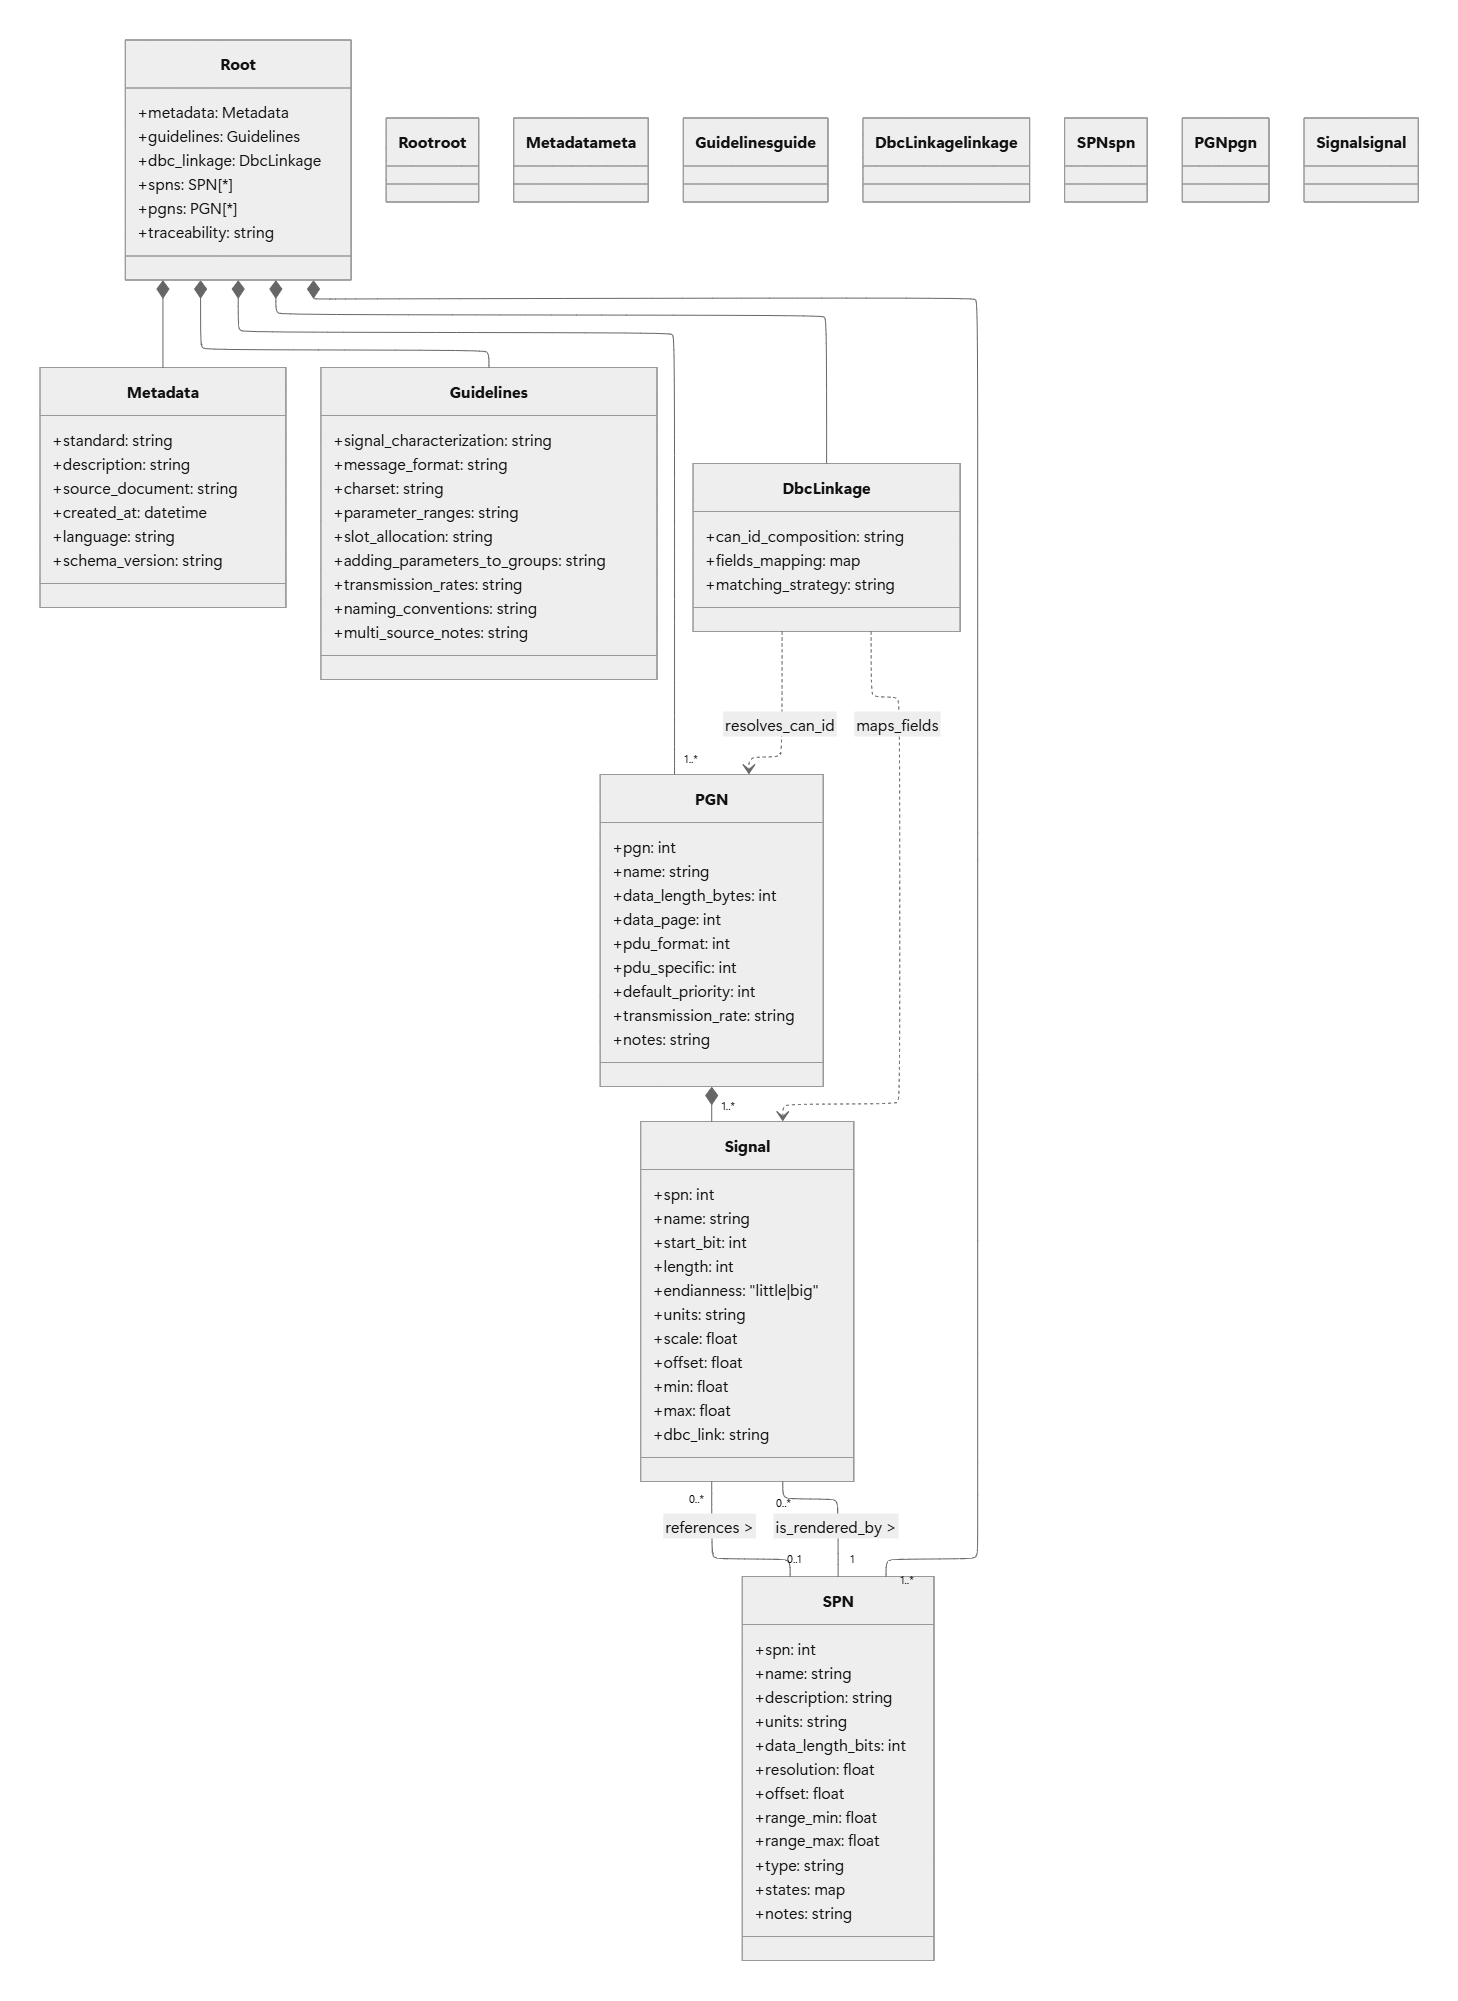

Política de vinculación con DBC:
- La clave semántica primaria es el SPN.
- Las posiciones de bits (start_bit, length) se confirman en el DBC.
- Se contrastan unidades, escala y offset para validar la correspondencia.


In [ ]:
# Verificación del JSON generado: conteos y muestras tabulares
from pathlib import Path
import json

JSON_PATH = Path(r'c:\\Users\\henry\\Documents\\GitHub\\Proyecto_Integrador_Grupo7_IBM\\Entrega4_Precision_Semantica_y_Contextualizacion_Eventos_Vehiculares\\j1939_71_reference.json')
print('JSON existe:', JSON_PATH.exists(), str(JSON_PATH))

if JSON_PATH.exists():
    with open(JSON_PATH, 'r', encoding='utf-8') as f:
        data = json.load(f)
    top_keys = list(data.keys())
    spns = data.get('spns', [])
    pgns = data.get('pgns', [])
    print('Claves de nivel superior:', top_keys)
    print('Total SPNs:', len(spns))
    print('Total PGNs:', len(pgns))
else:
    print('No se encontró el archivo JSON. Ejecute primero el pipeline de construcción.')

In [ ]:
# Tablas de ejemplo con pandas: primeras filas de SPNs y PGNs
import pandas as pd

if 'data' in globals():
    spn_df = pd.DataFrame(data.get('spns', []))
    pgn_df = pd.DataFrame(data.get('pgns', []))
    # Selección de columnas relevantes para vista rápida
    spn_cols = [c for c in ['spn', 'name', 'units', 'data_length_bits', 'resolution', 'offset', 'type', 'pgns'] if c in spn_df.columns]
    pgn_cols = [c for c in ['pgn', 'name', 'data_length_bytes', 'pdu_format', 'pdu_specific', 'default_priority', 'transmission_rate'] if c in pgn_df.columns]
    print('\nVista SPNs (primeras 15 filas):')
    display(spn_df[spn_cols].head(15))
    print('\nVista PGNs (primeras 10 filas):')
    display(pgn_df[pgn_cols].head(10))
else:
    print('No hay variable data cargada en memoria. Ejecute la celda anterior que carga el JSON.')

## 6. Validación y resultados

Al ejecutar el pipeline de extracción y ensamblado se obtuvieron conteos de SPNs y PGNs consistentes con lo esperado para las primeras páginas del documento, así como listados de ejemplo que muestran la correcta normalización de campos clave. Se verificó además que la estructura de claves de nivel superior del JSON coincide con la especificación definida para su consumo por RAG.

## 7. Rendimiento y contratiempos

Consideraciones de rendimiento:
- PyMuPDF (fitz) se empleó como motor por defecto por su rapidez en extracción de texto. Se estableció un procesamiento por bloques (p. ej., 10 páginas) con un buffer de cola (~2000 caracteres) para capturar bloques SPN que cruzan páginas.
- Se habilitó un límite de páginas (MAX_PAGES) para pruebas rápidas, incrementándolo gradualmente hasta procesar el documento completo.

Contratiempos y soluciones:
- Tiempos de ejecución prolongados con lectura secuencial de todo el documento: se resolvió con streaming por páginas y bloques.
- Variaciones de formato en el PDF que afectaban el regex: se robusteció el patrón para tolerar espacios y saltos de línea.
- Error de variable no definida en el notebook durante el ensamblado del JSON: se reescribió la celda para construir la estructura de manera autosuficiente.


## 8. Conclusiones

El pipeline implementado permite extraer de manera fiable las definiciones de SPN/PGN desde SAE J1939-71 y consolidarlas en un JSON apto para indexación semántica en RAG. Se logró una estructura clara y extensible, separando la semántica (SPN/PGN) de la disposición física de bits, que se delega al DBC. Las decisiones de diseño priorizaron robustez, rendimiento y trazabilidad.

Impacto esperado:
- Mejora en la precisión de recuperación contextual en el RAG al disponer de definiciones normalizadas y trazables.
- Aceleración del cruce con DBC al contar con una base organizada por SPN y PGN.

## 9. Próximos pasos

Acciones de mejora priorizadas:
1. Integración con DBC mediante cantools para derivar start_bit y length por señal y validar coherencia con el JSON.
2. Reglas adicionales de validación: detección de inconsistencias de unidades, offset y rangos por SPN.
3. Cobertura completa del documento: ejecución sin límite de páginas, con registro de métricas de desempeño.
4. Enriquecimiento semántico: adición de notas y estados enumerados cuando apliquen, y referencias cruzadas entre SPNs correlacionados.
5. Automatización CI: pruebas unitarias del parser con casos representativos y verificación de estructura del JSON antes de publicar artefactos.
